In [13]:
!kaggle competitions download -c nlp-getting-started
from zipfile import ZipFile
import os
for i in os.listdir(os.getcwd()):
    if '.zip' in i:
        print(i)
        with ZipFile(i, 'r') as zipObj:
            zipObj.extractall()
        os.remove(i)

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)
nlp-getting-started.zip


In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sbn
import matplotlib.pyplot as plt
import re
import os

import warnings
warnings.filterwarnings("ignore")

df=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [2]:
df['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [3]:
df.drop(['keyword','location','id'],axis=1,inplace=True)
df_test.drop(['keyword','location','id'],axis=1,inplace=True)
df

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


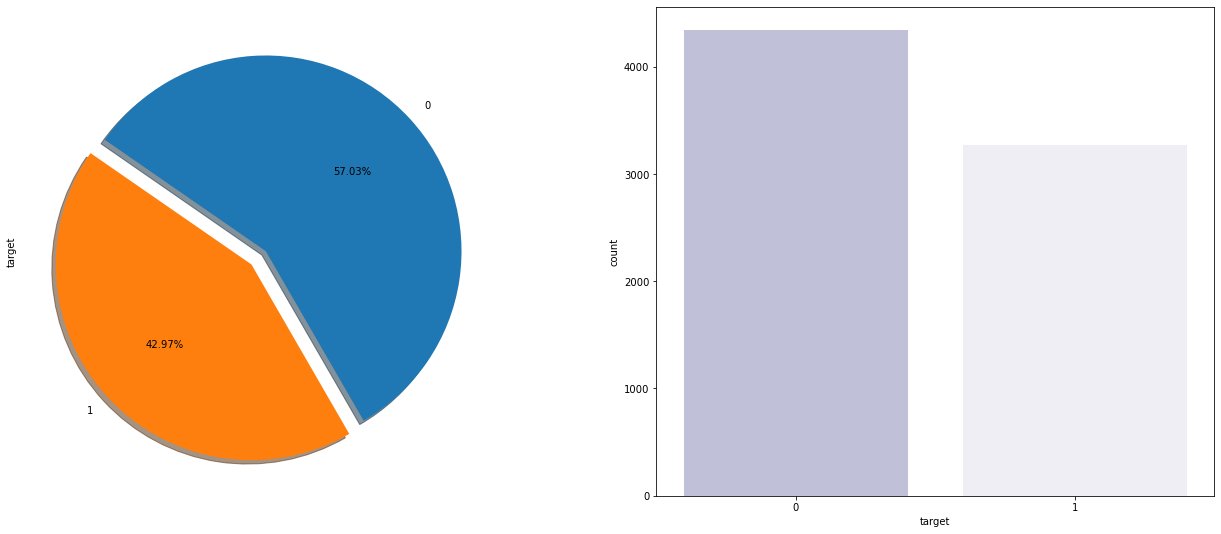

In [4]:
a , ax = plt.subplots(1,2,figsize=(22,9))
df['target'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.2f%%',ax=ax[0],shadow=True, startangle=300)


sbn.countplot('target', data = df ,ax=ax[1], palette=["#bcbddc", "#efedf5"])

In [5]:
df['text'].iloc[3]

'13,000 people receive #wildfires evacuation orders in California '

In [6]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
def process(review):
    review = re.sub("[^a-zA-Z]",' ',review)
    review = review.lower()
    review = review.split()
    swords = set(stopwords.words("english"))  # conversion into set for fast searching
    review = [w for w in review if w not in swords]               
    # splitted paragraph'ları space ile birleştiriyoruz return
    return(" ".join(review))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehmu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
train_data = []
for i in range(len(df["text"])):        
    if (i+1)%2500 == 0:        
        print("Result =", i+1)
    train_data.append(process(df["text"][i]))

Result = 2500
Result = 5000
Result = 7500


In [8]:
from sklearn.model_selection import train_test_split
X = train_data
y = np.array(df["text"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True,random_state=42)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 10000)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
sub = vectorizer.transform(df_test)

sub = sub.toarray()
X_train = X_train.toarray()
X_test = X_test.toarray()

In [10]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

In [11]:
classifiers = {
    "LR": LogisticRegression(max_iter=1000), 
    "LGBM": LGBMClassifier(),
    'CatBoost':CatBoostClassifier()
}

results = pd.DataFrame(columns=["Classifier", "Avg_Accuracy", "Avg_F1_Score"])
for name, clf in classifiers.items():
    print(name)
    model = clf
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    

    results = results.append({
        "Classifier": name,
        "Avg_Accuracy": accuracy_score(y_test, pred),
        "Avg_F1_Score": f1_score(y_test, pred)
    }, ignore_index=True)
    
results["Avg_Overall"] = (results["Avg_Accuracy"] + results["Avg_F1_Score"]) / 2
results = results.sort_values("Avg_Overall", ascending=False)
results

LR


In [ ]:
y_pred = clf.predict(sub)
y_pred= pd.DataFrame(y_pred)

y_pred

In [ ]:
submission = pd.read_csv("sample_submission.csv")
submission["target"] = y_pred
submission.to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"